# Training a MIL model for CT Intracranial Hemorrage Detection

The intracraneal hemorrage (ICH) is a serious life-threatening emergency caused by blood-leackage inside the brain. The presence of ICH is confirmed by radiologists by using a Computed Tomography (CT) scan, which consists of a significant number of slices, each representing a section of the head at a given height.

Training a model to detect ICH in CT scans is a challenging task, as it requires that a team of radiologists manually label each CT scan, indicating the presence of ICH in each slice. This is a time-consuming and expensive process, and it is not always feasible to obtain such detailed annotations for large datasets.

An alternative approach is to use Multiple Instance Learning (MIL), which allows us to train a model using weak labels. In this case, we can use the presence of ICH in the CT scan as a weak label, without requiring detailed annotations for each slice. In the following, we explain how to train a simple Multiple Instance Learning (MIL) model to detect ICH using the <tt>torchmil</tt> library.

!!! example "ICH detection as a MIL problem"
    
    We treat a CT scan as a bag of instances, where each instance is a slice of the CT scan. The bag is represented by a set of $N$ instances $\mathbf{x} = \left[ x_1, \ldots, x_N \right]^\top \in \mathbb{R}^{N \times d}$, where $d$ is the number of features per instance. Each instance is represented by a feature vector, which can be obtained by applying a feature extractor (e.g., a convolutional neural network) to the image of the slide.

    The labels of the slices are $\mathbf{y} = \left[ y_1, \ldots, y_N \right]^\top \in \{0, 1\}^N$. A slice will be given a positive label ($y_i = 1$) if it contains ICH, and a negative label ($y_i = 0$) if it does not. The labels of the slices are not available at training time, as they are usually obtained by a team of radiologists who manually annotate the CT scans. 
    
    In this case, we have access to the bag labels $Y \in \{0, 1\}$, which indicate whether the CT scan contains ICH or not. The relation between the instance labels and the bag label is as follows:

    $$ Y = \max \left\{ y_1, \ldots, y_N \right\} $$

    This means that if at least one slice in the CT scan has hemorrhage (i.e., $y_i = 1$), then the bag is labeled as positive ($Y = 1$). Otherwise, the bag is labeled as negative ($Y = 0$). This is a typical setting for MIL, where we have access to weak labels (the bag labels) but not to the instance labels.

## The data

For this tutorial, we will use the RSNA dataset, which can be found in [Kaggle](https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection). The dataset is composed of a set of CT scans, each containing a number of slices. Each slice is a 2D image, and the CT scan is a 3D volume. As part of <tt>torchmil</tt>, we have published a version of this dataset adapted for MIL, see the [Huggingface repository](https://huggingface.co/datasets/Franblueee/RSNA_ICH_MIL).

Let us first visualize the data using the `torchmil.visualize.vis_ctscan` module. In the following, we first load the slices of a bag and then use the function `slices_to_canvas` to create a canvas with all the images and we draw a small contour on each of the slices in the canvas using `draw_slices_contour`.

This scan has 30 slices


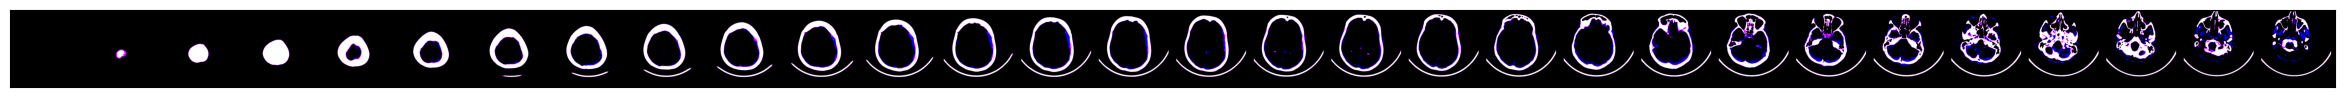

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# torchmil's facilities
from torchmil.visualize.vis_ctscan import slices_to_canvas, draw_slices_contour

CSV_PATH = '/data/datasets/RSNA_ICH/bags_train.csv' 
IMG_PATH = '/data/datasets/RSNA_ICH/original/'

# Randomly select a bag
df = pd.read_csv(CSV_PATH)
bag_names = df['bag_name'].unique()
bag_name = bag_names[np.random.randint(0, len(bag_names))] # Randomly select a bag

bag_df = df[df['bag_name'] == bag_name].sort_values('order')
inst_names = bag_df['instance_name'].values
inst_labels = bag_df['instance_label'].values
inst_names_list = [inst_name.split('.')[0] for inst_name in inst_names]
inst_imgs = [np.load(IMG_PATH + inst_name + '.npy') for inst_name in inst_names_list]
print("This scan has {} slices".format(len(inst_imgs)))

# Using torchmil's functions
canvas = slices_to_canvas(inst_imgs, 512) 
canvas_contours = draw_slices_contour(canvas, slice_size = 512, contour_prop = 0.05)

fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow((canvas_contours * 255).astype(np.uint8))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In practice, training a MIL model directly on the slices is computationally intractable. Due to this limitation, MIL models usually operate on pre-computed features extracted from each of the instances. Although <tt>torchmil</tt> allows to define models that receive the original slices as input, in this tutorial we will use the pre-computed. We have processed the RSNA dataset to be used for MIL binary classification problems. It can be downloaded from [here](https://huggingface.co/datasets/Franblueee/RSNA_ICH_MIL).

We now make use of `torchmil.datasets.RSNAMILDataset` to create an object that serves as a `torch.utils.data.Dataset` dataset and contains RSNA. You only need to provide the `root` path to the processed dataset, and the desired `features` and `partition` to load. See how simple is to instance the train dataset:

In [3]:
from torchmil.datasets import RSNAMILDataset
from sklearn.model_selection import train_test_split

dataset = RSNAMILDataset(
    root='/data/datasets/RSNA_ICH/MIL_processed/',
    features='resnet50',
    partition='train',
    load_at_init=True
)

# Split the dataset into train and validation sets
bag_labels = dataset.get_bag_labels()
idx = list(range(len(bag_labels)))
val_prop = 0.2
idx_train, idx_val = train_test_split(
    idx, test_size=val_prop, random_state=1234, stratify=bag_labels
)
train_dataset = dataset.subset(idx_train)
val_dataset = dataset.subset(idx_val)

test_dataset = RSNAMILDataset(
    root='/data/datasets/RSNA_ICH/MIL_processed/',
    features='resnet50',
    partition='test',
    load_at_init=True
)

In <tt>torchmil</tt>, each bag is a `TensorDict`. The different keys correspond to different elements of the bag. In this case, each bag has a feature matrix `X`, the bag label `Y`, the instance coordinates `coords`, and the instance labels `y_inst`. Recall that the instance labels cannot be used during training, they are available only for evaluation purposes.

In [4]:
bag = train_dataset[0]
print(bag)

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([30, 2048]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        coords: Tensor(shape=torch.Size([30, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([30]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)




## Mini-batching of bags

Tipically, the bags in a MIL dataset have different size. This can be a problem when creating mini-batches. To solve this, we use the function `collate_fn` from the [<tt><b>torchmil.data</b></tt>](../api/data/index.md) module. This function creates a mini-batch of bags by padding the bags with zeros to the size of the largest bag in the batch. The function also returns a mask tensor that indicates which instances are real and which are padding.

!!! question "Why not use [`torch.nested`](https://pytorch.org/docs/stable/nested.html)?"
    `torch.nested` offer a more flexible method for handling bags of varying sizes. However, since the PyTorch API for nested tensors is still in the prototype stage, <tt><b>torchmil</b></tt> currently relies on the padding approach.

Let's create the dataloaders and visualize the shape of a mini-batch. Since the RSNA dataset does not have many instances per bag, we can use a `batch_size` of 64 for the train and validation sets.

In [5]:
from torchmil.data import collate_fn

batch_size = 64

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


it = iter(train_dataloader)
batch = next(it)
data_shape = (batch['X'].shape[-1], )
print("Batch: ", batch)
print("Batch X shape: ", batch['X'].shape)
print("Batch Y shape: ", batch['Y'].shape)
print("Batch y_inst shape: ", batch['y_inst'].shape)
print("Batch mask shape: ", batch['mask'].shape)

Batch:  TensorDict(
    fields={
        X: Tensor(shape=torch.Size([64, 52, 2048]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([64]), device=cpu, dtype=torch.int64, is_shared=False),
        coords: Tensor(shape=torch.Size([64, 52, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([64, 52]), device=cpu, dtype=torch.uint8, is_shared=False),
        y_inst: Tensor(shape=torch.Size([64, 52]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)
Batch X shape:  torch.Size([64, 52, 2048])
Batch Y shape:  torch.Size([64])
Batch y_inst shape:  torch.Size([64, 52])
Batch mask shape:  torch.Size([64, 52])


Each batch is again a `TensorDict` with an additional key `mask` that indicates which instances are real and which are padding. As we can see, the bags are padded to the maximum size of the bags in the batch with zeros. The mask tensor indicates which elements are real instances and which are padding. The function `collate_fn` also pads other tensors, such as the adjacency matrix or the instance coordinates. 

## Training a model in RSNA

We have shown how to load the RSNA dataset for the binary classification task. Now, let us train a MIL model in this dataset! For this example, we will use <tt>torchmil</tt> implementation of a [TransformerABMIL](../api/models/transformer_abmil.md), a version of [ABMIL](../api/models/abmil.md) where a [Transformer encoder](../api/nn/transformers/conventional_transformer.md) is applied to refine the instances before the [Attention Pool](../api/nn/attention/attention_pool.md). To highlight how simple is to instance a model in <tt>torchmil</tt>, we will leave all the parameters by default except for the `in_shape`, which reflects the data shape. Feel free to check the [documentation of Transformer ABMIL](../api/models/transformer_abmil.md) to observe the different parameters that this model can be passed.

In [6]:
from torchmil.models import TransformerABMIL
model = TransformerABMIL(in_shape = data_shape)

See? It can not be easier! Now, let's train the model. <tt>torchmil</tt> offers an easy-to-use trainer class located in `torchmil.utils.trainer.Trainer` that provides a generic training for any MIL model. Also, it will show the evolution of the losses and the desired metrics during the epochs.

!!! note
    This `Trainer` gives the flexibility to log the results using any wrapped `logger`, use annealing for the loss functions via the `annealing_scheduler_dict` dictionary, or to set a learning rate scheduler using the parameter `lr_scheduler`. Also, you can follow multiple metrics during the training thanks to the parameter `metrics_dict` and the integration with the <tt>torchmetrics</tt> package.

For now, let us just keep it simple and perform a simple training using the `torch.optim.Adam` optimizer and training the model for 10 epochs. First, we instance the trainer.

In [7]:
from torchmil.utils.trainer import Trainer
import torchmetrics
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    metrics_dict={
        'auroc': torchmetrics.AUROC(task='binary').to(device),
        'acc': torchmetrics.Accuracy(task='binary').to(device)
    },
    obj_metric='BCEWithLogitsLoss',
    obj_metric_mode='min',
    device='cuda'
)

trainer.train(
    max_epochs=10,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

[Epoch 1] Test : 100%|██████████| 3/3 [00:00<00:00, 26.07it/s, test/loss=0.612, test/BCEWithLogitsLoss=0.612, test/auroc=0.778, test/acc=0.653]


Best BCEWithLogitsLoss: inf, Current BCEWithLogitsLoss: 0.5677191019058228


[Epoch 2] Test : 100%|██████████| 3/3 [00:00<00:00, 25.83it/s, test/loss=0.495, test/BCEWithLogitsLoss=0.495, test/auroc=0.821, test/acc=0.74]


Best BCEWithLogitsLoss: 0.5677191019058228, Current BCEWithLogitsLoss: 0.48895183205604553


[Epoch 3] Test : 100%|██████████| 3/3 [00:00<00:00, 25.39it/s, test/loss=0.425, test/BCEWithLogitsLoss=0.425, test/auroc=0.885, test/acc=0.827]


Best BCEWithLogitsLoss: 0.48895183205604553, Current BCEWithLogitsLoss: 0.4151015877723694


[Epoch 4] Test : 100%|██████████| 3/3 [00:00<00:00, 25.80it/s, test/loss=0.414, test/BCEWithLogitsLoss=0.414, test/auroc=0.892, test/acc=0.86]


Best BCEWithLogitsLoss: 0.4151015877723694, Current BCEWithLogitsLoss: 0.36116036772727966


[Epoch 5] Test : 100%|██████████| 3/3 [00:00<00:00, 26.02it/s, test/loss=0.422, test/BCEWithLogitsLoss=0.422, test/auroc=0.899, test/acc=0.813]


Best BCEWithLogitsLoss: 0.36116036772727966, Current BCEWithLogitsLoss: 0.42345672845840454
Early stopping count: 1


[Epoch 6] Test : 100%|██████████| 3/3 [00:00<00:00, 28.43it/s, test/loss=0.476, test/BCEWithLogitsLoss=0.476, test/auroc=0.912, test/acc=0.773]


Best BCEWithLogitsLoss: 0.36116036772727966, Current BCEWithLogitsLoss: 0.3664763569831848
Early stopping count: 2


[Epoch 7] Test : 100%|██████████| 3/3 [00:00<00:00, 29.37it/s, test/loss=0.369, test/BCEWithLogitsLoss=0.369, test/auroc=0.916, test/acc=0.853]


Best BCEWithLogitsLoss: 0.36116036772727966, Current BCEWithLogitsLoss: 0.32695162296295166


[Epoch 8] Test : 100%|██████████| 3/3 [00:00<00:00, 29.38it/s, test/loss=0.424, test/BCEWithLogitsLoss=0.424, test/auroc=0.906, test/acc=0.84]


Best BCEWithLogitsLoss: 0.32695162296295166, Current BCEWithLogitsLoss: 0.3184625506401062


[Epoch 9] Test : 100%|██████████| 3/3 [00:00<00:00, 28.07it/s, test/loss=0.404, test/BCEWithLogitsLoss=0.404, test/auroc=0.913, test/acc=0.853]


Best BCEWithLogitsLoss: 0.3184625506401062, Current BCEWithLogitsLoss: 0.28652310371398926


[Epoch 10] Test : 100%|██████████| 3/3 [00:00<00:00, 28.92it/s, test/loss=0.387, test/BCEWithLogitsLoss=0.387, test/auroc=0.924, test/acc=0.86]

Best BCEWithLogitsLoss: 0.28652310371398926, Current BCEWithLogitsLoss: 0.30848753452301025
Early stopping count: 1


The loss decreases as the model learns to predict the bag labels. The accuracy increases as the model learns to predict the correct bag labels. This is a good sign that the model is learning! 

## Evaluating the model

Let's evaluate the model. We are going to compute the accuracy and f1-score on the test set. The accuracy is the proportion of correctly classified bags, while the f1-score is the harmonic mean of precision and recall. The f1-score is a good metric for imbalanced datasets.
Typically, in MIL datasets, there are more negative bags than positive bags.

In [8]:
from sklearn.metrics import accuracy_score, f1_score

inst_pred_list = []
y_inst_list = []
Y_pred_list = []
Y_list = []

model.eval()

for batch in test_dataloader:
    batch = batch.to(device)
    
    # predict bag label using our model
    out = model(batch['X'], batch['mask'])
    Y_pred = (out > 0).float()

    Y_pred_list.append(Y_pred)
    Y_list.append(batch['Y'])

Y_pred = torch.cat(Y_pred_list).cpu().numpy()
Y = torch.cat(Y_list).cpu().numpy()

print(f"test/bag/acc: {accuracy_score(Y_pred, Y)}")
print(f"test/bag/f1: {f1_score(Y_pred, Y)}")

test/bag/acc: 0.86
test/bag/f1: 0.8551724137931035


Good! Our model is working well. The accuracy and f1-score are high. And we got this result in less than two minutes on <tt>GPU</tt> and very few lines of code thanks to <tt>torchmil</tt>!